In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import math
from collections import Counter
# import numpy as np
import seaborn as sns
# import pandas as pd
import scipy.stats as ss
# import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from subprocess import check_output

In [2]:
#Dataframe Visual Settings
pd.set_option('display.max_rows',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',400)

In [52]:
df = pd.read_excel('bank_statements_categorized.xlsx')

In [4]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

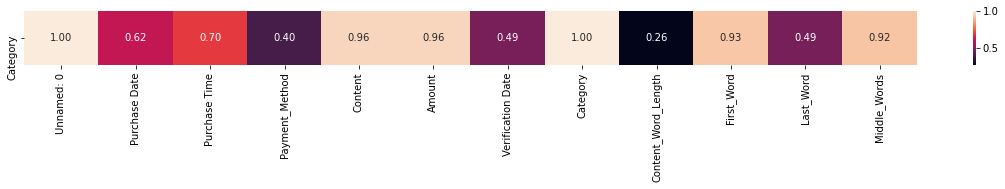

In [5]:
theilu = pd.DataFrame(index=['Category'],columns=df.columns)
columns = df.columns
for j in range(0,len(columns)):
    u = theil_u(df['Category'].tolist(),df[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

In [53]:
df.drop(['Content','Middle_Words'],axis=1,inplace=True)

In [19]:
def clean_bank_statement_file(filename):
    """
    Extract, modify & clean bank statement raw file for neater format
    """
    #Cleaning data
    # csv_file = '\Bank Statements\'' + filename
    df = pd.read_csv(filename,
                     usecols=['Transaction Number','Date','Memo','Amount Debit','Amount Credit'],
                     skiprows=3)
    
    df.fillna({'Amount Debit':0, 'Amount Credit':0},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df.sort_values(by=['Date'],ascending=False,ignore_index=True,inplace=True)
    df['Memo'].fillna('Default',inplace=True)
    df['Transaction Number'] = df['Transaction Number'].apply(lambda x: x.split('**')[1])
    df['Purchase Date'] = df[df['Memo'].str.contains('1574 ',na=False)]['Memo']\
        .apply(lambda x: x.split('1574 ')[1])
    df['Purchase Date'] = pd.to_datetime(df['Purchase Date'],format = '%m/%d %H:%M')
    df['Purchase Date'] = df['Purchase Date']+pd.DateOffset(years=120)
    df.loc[df['Purchase Date'].isna(),'Purchase Date'] = df['Date'].copy()
    df['Memo'] = df['Memo'].apply(lambda x: x.split('*****')[0])
    df['Content'] = df['Transaction Number'] + ' ' + df['Memo']
    df['Amount'] = df['Amount Debit'].astype(float) + df['Amount Credit'].astype(float)
    df['Category'] = 'Default'
    df.drop(df[df['Content'].str.contains("INTERNET TRANSFER",na=False)].index,inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.drop(['Transaction Number','Memo','Amount Debit','Amount Credit'],
            axis=1,inplace=True)
    df.sort_values(by=['Purchase Date'],ascending=False, inplace=True)
    return df

In [20]:
feb_df = clean_bank_statement_file('FebruaryChecking.csv')

In [54]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
df.columns

Index(['Unnamed: 0', 'Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Category', 'Content_Word_Length', 'First_Word', 'Last_Word'], dtype='object')

In [9]:
feb_df.head()

,Date,Purchase Date,Content,Amount,Category
2,2021-02-25,2021-02-25,Feb 2nd Paycheck Savings TO: DDXXXX5941,-173.82,Default
3,2021-02-24,2021-02-24,VZ WIRELESS VE/VZW WEBPAYWALTER *COLEMAN,-104.20,Default
4,2021-02-24,2021-02-24,Pillar DC/Pillar DCPILLAR CHURCH OF WASHI,-310.97,Default
6,2021-02-23,2021-02-23,VENMO/PAYMENTWALTER COLEMAN Default,-46.41,Default
16,2021-02-22,2021-02-22,USAA PC/PAYMENTWALTER COLEMAN Default,-187.68,Default


In [55]:
df = df[['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length',\
         'First_Word', 'Last_Word', 'Category']].copy()

In [12]:
def PIN_col(x):
    if("POS PURCHASE Non-PIN" in x):
        return "POS PURCHASE Non-PIN"
    elif("POS PURCHASE with PIN" in x):
        return "POS PURCHASE with PIN"
    elif("VENMO" in x):
        return "VENMO"
    else:
        return "Other"

def remove_payment_method(x):
    if("POS PURCHASE Non-PIN" in x):
        return x.split("POS PURCHASE Non-PIN")[1]
    elif("POS PURCHASE with PIN" in x):
        return x.split("POS PURCHASE with PIN")[1]
    else:
        return x

In [14]:
df.columns

Index(['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length', 'First_Word', 'Last_Word', 'Category'], dtype='object')

In [23]:
#Purchase Time
feb_df['Purchase Time'] = [d.time() for d in feb_df['Purchase Date']] #then rewrite Purchase Date
#Purchase Date
feb_df['Purchase Date'] = [d.date() for d in feb_df['Purchase Date']]
#Payment Method
feb_df['Payment_Method'] = feb_df['Content'].apply(lambda x: PIN_col(x))
feb_df["Content"] = feb_df["Content"].apply(lambda x: remove_payment_method(x))
#Amount (got it)
#Verification Date
feb_df['Verification Date'] = feb_df['Date'].copy()
feb_df.drop('Date', axis=1, inplace=True)
#Category
#Independent variable

#Content_Word_Length
feb_df['Content_Word_Length'] = feb_df['Content'].apply(lambda x: len(x.split(' ')))
#First_Word
feb_df['First_Word'] = feb_df['Content'].apply(lambda x: x.split(' ')[0])
#Last_Word
feb_df['Last_Word'] = feb_df['Content'].apply(lambda x: x.split(' ')[-1])

In [24]:
feb_df.columns

Index(['Purchase Date', 'Content', 'Amount', 'Category', 'Purchase Time', 'Payment_Method', 'Verification Date', 'Content_Word_Length', 'First_Word', 'Last_Word'], dtype='object')

In [25]:
feb_df = feb_df[['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date',\
                 'Content_Word_Length', 'First_Word', 'Last_Word']].copy()

In [27]:
feb_df.columns

Index(['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length', 'First_Word'], dtype='object')

In [30]:
df.columns[:-1] == feb_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [31]:
features = df.drop('Category',axis=1)
labels = df['Category']

In [32]:
test_feats = feb_df

In [33]:
enc = OrdinalEncoder()

In [40]:
features

,Purchase Date,Purchase Time,Payment_Method,Amount,Verification Date,Content_Word_Length,First_Word,Last_Word
0,2021-01-29,00:00:00,Other,-187.68,2021-01-29,4,USAA,Default
1,2021-01-27,00:00:00,VENMO,669.80,2021-01-27,3,VENMO/CASHOUTWALTER,Default
2,2021-01-21,00:00:00,Other,2099.81,2021-01-21,5,Accenture,J
3,2021-01-20,00:00:00,VENMO,-845.00,2021-01-20,3,VENMO/PAYMENTWALTER,Default
4,2021-01-20,00:00:00,VENMO,-48.22,2021-01-20,3,VENMO/PAYMENTWALTER,Default
5,2021-01-07,00:00:00,Other,-339.23,2021-01-07,6,Pillar,WASHI
6,2021-01-06,00:00:00,Other,2262.00,2021-01-06,5,Accenture,J
7,2021-01-06,00:00:00,VENMO,-26.12,2021-01-06,3,VENMO/PAYMENTWALTER,Default
8,2021-01-06,00:00:00,Other,-60.00,2021-01-06,6,Pillar,WASHI
9,2021-01-05,00:00:00,Other,175.00,2021-01-05,4,Mobile,Default


In [37]:
features['Last_Word'].fillna('N/A',inplace=True)

In [42]:
features['First_Word'].fillna('N/A',inplace=True)

In [43]:
features.isnull().sum() * 100 / len(features)

Purchase Date          0.0
Purchase Time          0.0
Payment_Method         0.0
Amount                 0.0
Verification Date      0.0
Content_Word_Length    0.0
First_Word             0.0
Last_Word              0.0
dtype: float64

In [39]:
labels

0                USAA Insurance
1                   Venmo Extra
2                     Pay Check
3                          Rent
4                     Utilities
5                         Tithe
6                     Pay Check
7                     Utilities
8                         Tithe
9                         Extra
10                        Extra
11                   Dining Out
12                   Dining Out
13                         Misc
14                         Misc
15                          Gas
16     Tolls/Uber/Metro/Parking
17     Tolls/Uber/Metro/Parking
18                         Misc
19                      Medical
20                         Misc
21                   Dining Out
22                   Dining Out
23                   Dining Out
24                   Dining Out
25                   Dining Out
26                        Phone
27                    Utilities
28                  Venmo Extra
29                    Groceries
30                   Dining Out
31     T

In [56]:
df[['First_Word','Last_Word']] = df[['First_Word','Last_Word']].fillna('N/A').copy()

In [51]:
df

array([[269.,   0.,   0., ..., 144.,  48.,  14.],
       [268.,   0.,   3., ..., 149.,  48.,  16.],
       [267.,   0.,   0., ...,  20.,  94.,   8.],
       ...,
       [  2.,  23.,   1., ..., 121.,  96.,   0.],
       [  1., 115.,   1., ...,  51.,  96.,   7.],
       [  0., 350.,   2., ...,  68.,  96.,   4.]])

In [57]:
df.columns

Index(['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length', 'First_Word', 'Last_Word', 'Category'], dtype='object')

In [86]:
df[['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length',\
    'First_Word', 'Last_Word', 'Category']] = enc.fit_transform(df[['Purchase Date', 'Purchase Time',\
    'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length', 'First_Word', 'Last_Word',\
                                                                    'Category']])

In [87]:
df = enc.inverse_transform(df[['Purchase Date', 'Purchase Time','Payment_Method', 'Amount', 'Verification Date',\
                               'Content_Word_Length', 'First_Word', 'Last_Word','Category']])

In [59]:
df

,Purchase Date,Purchase Time,Payment_Method,Amount,Verification Date,Content_Word_Length,First_Word,Last_Word,Category
0,269.0,0.0,0.0,42.0,180.0,2.0,144.0,48.0,14.0
1,268.0,0.0,3.0,531.0,179.0,1.0,149.0,48.0,16.0
2,267.0,0.0,0.0,537.0,175.0,3.0,20.0,94.0,8.0
3,266.0,0.0,3.0,10.0,174.0,1.0,150.0,48.0,10.0
4,266.0,0.0,3.0,108.0,174.0,1.0,150.0,48.0,15.0
5,265.0,0.0,0.0,19.0,167.0,4.0,113.0,101.0,12.0
6,264.0,0.0,0.0,542.0,166.0,3.0,20.0,94.0,8.0
7,264.0,0.0,3.0,185.0,166.0,1.0,150.0,48.0,15.0
8,264.0,0.0,0.0,92.0,166.0,4.0,113.0,101.0,12.0
9,263.0,0.0,0.0,521.0,165.0,2.0,92.0,48.0,2.0


In [60]:
features = df.drop('Category',axis=1)
labels = df['Category']

In [61]:
#Encode train df's, labels & test_df (February checking)
rfc = RandomForestClassifier(max_depth=9,random_state=42)

In [62]:
#Train the model
rfc.fit(features,labels)

RandomForestClassifier(max_depth=9, random_state=42)

In [63]:
feb_df.columns

Index(['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length', 'First_Word', 'Last_Word'], dtype='object')

In [64]:
feb_df[['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length',\
        'First_Word', 'Last_Word']] = enc.fit_transform(feb_df[['Purchase Date', 'Purchase Time',\
        'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length', 'First_Word', 'Last_Word']])

In [66]:
#predict the categories
predictions = rfc.predict(feb_df)

In [97]:
feb_df['Category'] = predictions

In [68]:
feb_df

,Purchase Date,Purchase Time,Payment_Method,Amount,Verification Date,Content_Word_Length,First_Word,Last_Word,Category
2,31.0,0.0,0.0,7.0,14.0,3.0,14.0,4.0,11.0
3,30.0,0.0,0.0,9.0,13.0,2.0,36.0,1.0,11.0
4,30.0,0.0,0.0,2.0,13.0,3.0,26.0,9.0,11.0
6,29.0,0.0,3.0,19.0,12.0,0.0,35.0,5.0,4.0
16,28.0,0.0,0.0,6.0,11.0,1.0,34.0,5.0,11.0
18,28.0,0.0,3.0,0.0,11.0,0.0,35.0,5.0,4.0
17,28.0,0.0,3.0,12.0,11.0,0.0,35.0,5.0,4.0
21,27.0,0.0,0.0,67.0,10.0,2.0,6.0,8.0,15.0
27,26.0,0.0,0.0,64.0,7.0,2.0,20.0,4.0,15.0
26,26.0,0.0,0.0,65.0,7.0,2.0,20.0,5.0,15.0


In [71]:
df.columns

Index(['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length', 'First_Word', 'Last_Word', 'Category'], dtype='object')

In [75]:
enc.inverse_transform(df[['Purchase Date', 'Purchase Time', 'Payment_Method', 'Amount', 'Verification Date', 'Content_Word_Length',\
    'First_Word', 'Last_Word']])

IndexError: index 269 is out of bounds for axis 0 with size 32

In [77]:
category_backup = df['Category']

In [78]:
category_backup.head()

0    14.0
1    16.0
2     8.0
3    10.0
4    15.0
Name: Category, dtype: float64

In [80]:
df.loc[269]

Purchase Date          180.0
Purchase Time          152.0
Payment_Method           1.0
Amount                 104.0
Verification Date      105.0
Content_Word_Length      4.0
First_Word               6.0
Last_Word               96.0
Category                 6.0
Name: 269, dtype: float64

In [81]:
df

,Purchase Date,Purchase Time,Payment_Method,Amount,Verification Date,Content_Word_Length,First_Word,Last_Word,Category
0,269.0,0.0,0.0,42.0,180.0,2.0,144.0,48.0,14.0
1,268.0,0.0,3.0,531.0,179.0,1.0,149.0,48.0,16.0
2,267.0,0.0,0.0,537.0,175.0,3.0,20.0,94.0,8.0
3,266.0,0.0,3.0,10.0,174.0,1.0,150.0,48.0,10.0
4,266.0,0.0,3.0,108.0,174.0,1.0,150.0,48.0,15.0
5,265.0,0.0,0.0,19.0,167.0,4.0,113.0,101.0,12.0
6,264.0,0.0,0.0,542.0,166.0,3.0,20.0,94.0,8.0
7,264.0,0.0,3.0,185.0,166.0,1.0,150.0,48.0,15.0
8,264.0,0.0,0.0,92.0,166.0,4.0,113.0,101.0,12.0
9,263.0,0.0,0.0,521.0,165.0,2.0,92.0,48.0,2.0


In [82]:
df = enc.inverse_transform(df[['Purchase Date', 'Purchase Time','Payment_Method', 'Amount', 'Verification Date',\
                               'Content_Word_Length', 'First_Word', 'Last_Word','Category']])

ValueError: Shape of the passed X data is not correct. Expected 8 columns, got 9.

In [85]:
len(df.columns)

9

In [90]:
feb_df.drop('Category',axis=1,inplace=True)

In [100]:
feb_df[['Purchase Date', 'Purchase Time','Payment_Method', 'Amount', 'Verification Date',\
                               'Content_Word_Length', 'First_Word', 'Last_Word','Category']] = enc.inverse_transform(feb_df[['Purchase Date', 'Purchase Time','Payment_Method', 'Amount', 'Verification Date',\
                               'Content_Word_Length', 'First_Word', 'Last_Word','Category']])

In [101]:
feb_df

,Purchase Date,Purchase Time,Payment_Method,Amount,Verification Date,Content_Word_Length,First_Word,Last_Word,Category
2,31.0,0.0,0.0,7.0,14.0,3.0,14.0,4.0,11.0
3,30.0,0.0,0.0,9.0,13.0,2.0,36.0,1.0,11.0
4,30.0,0.0,0.0,2.0,13.0,3.0,26.0,9.0,11.0
6,29.0,0.0,3.0,19.0,12.0,0.0,35.0,5.0,4.0
16,28.0,0.0,0.0,6.0,11.0,1.0,34.0,5.0,11.0
18,28.0,0.0,3.0,0.0,11.0,0.0,35.0,5.0,4.0
17,28.0,0.0,3.0,12.0,11.0,0.0,35.0,5.0,4.0
21,27.0,0.0,0.0,67.0,10.0,2.0,6.0,8.0,15.0
27,26.0,0.0,0.0,64.0,7.0,2.0,20.0,4.0,15.0
26,26.0,0.0,0.0,65.0,7.0,2.0,20.0,5.0,15.0


In [102]:
feb_df = enc.inverse_transform(feb_df)

In [103]:
feb_df

array([[31.,  0.,  0.,  7., 14.,  3., 14.,  4., 11.],
       [30.,  0.,  0.,  9., 13.,  2., 36.,  1., 11.],
       [30.,  0.,  0.,  2., 13.,  3., 26.,  9., 11.],
       [29.,  0.,  3., 19., 12.,  0., 35.,  5.,  4.],
       [28.,  0.,  0.,  6., 11.,  1., 34.,  5., 11.],
       [28.,  0.,  3.,  0., 11.,  0., 35.,  5.,  4.],
       [28.,  0.,  3., 12., 11.,  0., 35.,  5.,  4.],
       [27.,  0.,  0., 67., 10.,  2.,  6.,  8., 15.],
       [26.,  0.,  0., 64.,  7.,  2., 20.,  4., 15.],
       [26.,  0.,  0., 65.,  7.,  2., 20.,  5., 15.],
       [25.,  0.,  0., 13.,  4.,  2., 36.,  1., 11.],
       [25.,  0.,  3., 28.,  4.,  0., 35.,  5.,  4.],
       [25.,  0.,  3., 38.,  4.,  0., 35.,  5.,  4.],
       [25.,  0.,  0.,  3.,  4.,  3., 26.,  9., 11.],
       [24.,  0.,  0., 66.,  3.,  2.,  6.,  8., 15.],
       [23., 10.,  1., 52., 15.,  4., 30.,  0.,  7.],
       [22., 14.,  1., 57., 14.,  2., 22.,  0.,  7.],
       [21., 37.,  2., 27., 13.,  5., 16.,  0.,  4.],
       [20., 19.,  1., 11., 